Checking if Hamiltonian remains constant across iterations of leapfrog integrator:

In [1]:
import numpy as np, numpy.random as npr, torch.nn as nn, copy, timeit, torch
from torch.distributions.bernoulli import Bernoulli 
from HMCfunctions import *
from time import time
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import plot, show, legend

In [4]:
def leapfrog(nn_model, n_leapfrog, delta_leapfrog, shapes, x, y, prior_sigma, error_sigma=1) :
    
    kinetic_energy = np.zeros(n_leapfrog)
    potential_energy = np.zeros(n_leapfrog)
    
    update_grads(nn_model, x, y)
    
    mom = generate_momentum(shapes)  # Generate momentum variables
    current_mom = copy.deepcopy(mom) # keep copy of initial momentum 
    
    # half step for momentum at beginning
    update_mom(mom, nn_model, delta_leapfrog/2, x, y, prior_sigma, error_sigma)        
    
    # leapfrog steps:
    for l in range(n_leapfrog) :
        # Full step for position
        update_pos(mom, nn_model, delta_leapfrog, x, y, prior_sigma, error_sigma)
        # update gradients based on new parameters (ie, new positions):
        update_grads(nn_model, x, y)
        
        # full step for momentum, except at end 
        if l < n_leapfrog-1 :
            update_mom(mom, nn_model, delta_leapfrog, x, y, prior_sigma, error_sigma)
        
        kinetic_energy[l] = eval_kinetic_energy(mom) 
        potential_energy[l] = eval_potential_energy(nn_model, x, y, prior_sigma, error_sigma)
                
    # half step for momentum at end :
    update_mom(mom, nn_model, delta_leapfrog/2, x, y, prior_sigma, error_sigma)
        
    # Negate momentum at end to make proposal symmetric
    for i in range(len(mom)) :
        mom[i].mul_(-1)

    return mom, current_mom, nn_model, kinetic_energy, potential_energy

In [5]:
n_in = 1
# n_h1 = 5
# n_h2 = 10
n_out = 2

In [6]:
nobs = 1_00
x = torch.rand(nobs, n_in)
y = np.zeros((nobs, n_out))
y[:,0] = list(np.cos(2*np.pi*x))
y[:,1] = list(np.sin(2*np.pi*x))
y = torch.from_numpy(y).float()
criterion = nn.MSELoss()

In [23]:
nn_model = nn.Sequential(nn.Linear(n_in, n_out))
nn_model.apply(init_normal)

Sequential(
  (0): Linear(in_features=1, out_features=2, bias=True)
)

In [24]:
shapes = get_shapes(nn_model)
print("Shapes = ", shapes)

Shapes =  [torch.Size([2, 1]), torch.Size([2])]


In [25]:
delta_leapfrog = 1e-1
n_leapfrog = 10**3
prior_sigma = 1
error_sigma = 1

In [26]:
_, _, _, kinetic_energy, potential_energy = leapfrog(nn_model, 
                                                     n_leapfrog, 
                                                     delta_leapfrog,
                                                     shapes, 
                                                     x, y, 
                                                     prior_sigma, 
                                                     error_sigma)

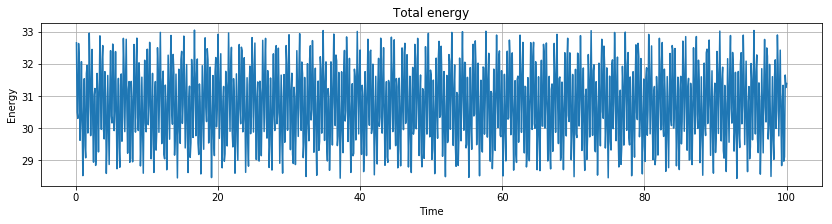

In [27]:
plt.figure(figsize=(14,3))
plt.plot(delta_leapfrog*np.arange(1,n_leapfrog+1), kinetic_energy+potential_energy)
plt.grid(True)
plt.title("Total energy")
plt.xlabel("Time")
plt.ylabel("Energy");